###### To be run in CMSSW_10_2_3 with adding:
pip install --user joblib scikit-learn==0.20.4

Like v2 but with BTD trained in signal region

# Imports

In [1]:
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

In [2]:
from __future__ import print_function

import h5py, os, sys, datetime, time
sys.path.append('../lib')
from glob import glob
import numpy as np
import scipy as sp
from scipy.special import erf

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
from matplotlib.colors import LogNorm

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import joblib
import pickle
from prettytable import PrettyTable
import ROOT as rt
rt.PyConfig.IgnoreCommandLineOptions = True
rt.gROOT.SetBatch()
rt.gErrorIgnoreLevel = rt.kError

from histo_utilities import create_TH2D, create_TH1D, create_Canvas, make_effiency_plot, rootTH1_to_np
from progressBar import ProgressBar
from cebefo_style import cebefo_style

cebefo_style()


dnd = []

Welcome to JupyROOT 6.12/07


In [3]:
# Thong's DNN imports
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, Lambda
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

Using TensorFlow backend.


In [4]:
from reading_util import *
from writing_util import *
import string_constants as sc

In [5]:
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

## constants CHANGE HERE!!!

In [6]:
Mjj_selection = 1100.

SM_eff = 1e-2 #1e-2
QR_train_share = 0.25 #0.2
SM_sample = 'qcdSigAll'

# String constants

In [7]:
vae_model = 'pt_normalized'
vae_train_data = 'training_without_pt_cut'

base_dir = os.path.join('/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results',vae_model,vae_train_data)
#file_dir = os.path.join(base_dir,'qcd_sqrtshatTeV_13TeV_PU40_SIGNALREGION_ALL')

file_dir = os.path.join( sc.concat_result_dir, sc.sample_loc[SM_sample] + sc.concat_result_suffix )
qr_data = 'qcd_signal'

qr_train_share = str(int(QR_train_share*100))+'pct'
quantile = 'qr_'+str(int(SM_eff*100))+'pct'

fig_dir = os.path.join('fig',vae_model,vae_train_data,qr_data+'_'+qr_train_share+'_qr_train',quantile)
!mkdir -p $fig_dir
print('plotting to', fig_dir)

plotting to fig/pt_normalized/training_without_pt_cut/qcd_signal_25pct_qr_train/qr_1pct


# Function Definitions

In [8]:
loss_scaling = 1.0
Mjj_scaling = 2000.0

def scaleDownMjj(x):
    return (x-2*Mjj_selection)/Mjj_scaling
    #return x
    
def computeDiscriminatingVar_sum(x):
    out = x['j1TotalLoss']+x['j2TotalLoss']
    out *= loss_scaling #1e9
    return out

def computeDiscriminatingVar_str_sum(l1, l2):
    out = loss_scaling*(l1+l2)
    return out

def computeDiscriminatingVar_min(x):
    out = np.minimum(x['j1TotalLoss'],x['j2TotalLoss'])
    out *= loss_scaling #1e9
    return out

def computeDiscriminatingVar_str_min(l1, l2):
    out = loss_scaling*np.minimum(l1,l2)
    return out


# set loss strategy to be used
computeDiscriminatingVar = computeDiscriminatingVar_min
computeDiscriminatingVar_str = computeDiscriminatingVar_str_min

In [9]:
def plot_hist( data, xlabel, ylabel, title, plotname='', legend=[], ylogscale=True ):
    fig = plt.figure( )
    plot_hist_on_axis( plt.gca(), data, xlabel, ylabel, title, legend, ylogscale )
    if legend:
        plt.legend()
    plt.tight_layout()
    fig.savefig(os.path.join(fig_dir, plotname + '_hist.png'))
    plt.close()


def plot_hist_on_axis( ax, data, xlabel, ylabel, title, legend=[], ylogscale=True ):
    bin_num = 70
    alpha = 0.85
    if ylogscale:
        ax.set_yscale('log', nonposy='clip')
    ax.hist( data, bins=bin_num, normed=True, alpha=alpha, histtype='stepfilled', label=legend )
    ax.set_ylabel( ylabel )
    ax.set_xlabel( xlabel )
    ax.set_title( title, fontsize=10 )
    ax.tick_params(axis='both', which='minor', labelsize=8)
    #ax.set_ylim(bottom=1e-7)



In [10]:
def plot_hist_2d( x, y, xlabel, ylabel, title, plotname=''):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.gca()
    im = plot_hist_2d_on_axis( ax, x, y, xlabel, ylabel, title )
    fig.colorbar(im[3])
    plt.tight_layout()
    fig.savefig(os.path.join(fig_dir, plotname + '_hist_2d.png'))
    plt.close()
    #plt.draw()

def plot_hist_2d_on_axis( ax, x, y, xlabel, ylabel, title ):
    im = ax.hist2d(x, y, bins=100, norm=colors.LogNorm())
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_ylim(top=70.)
    return im 

# Get the qcd sample for trainig

In [11]:
qcd_data_total, labels = read_results_to_recarray( file_dir )
#qcd_data_total, labels = read_in_single_result_file(os.path.join(file_dir,'qcd_sqrtshatTeV_13TeV_PU40_SIGNALREGION_ALL_mjj_cut_1100GeV_concat.h5'))
N_evts = qcd_data_total.shape[0]
print("\nnum evts read: ", N_evts)
QCD_xsec = 8.73e-6 #mb
QCD_xsec *= 1e9 #fb # ??????
print('\nLuminosity used for training')
print('{:.2} fb^-1'.format(N_evts/QCD_xsec))
        

('reading', '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_without_pt_cut/qcd_sqrtshatTeV_13TeV_PU40')
('reading ', '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_without_pt_cut/qcd_sqrtshatTeV_13TeV_PU40')
('num files in dir:', 2147)
[--------------------]  0% - ETA:  6.9 h   ('Labels:', array(['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M',
       'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j1RecoLoss',
       'j1KlLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss'], dtype='|S11'))
('\nnum files read in dir ', '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_without_pt_cut/qcd_sqrtshatTeV_13TeV_PU40', ': ', 2147)

num evts read:  4623774

Luminosity used for training
5.3e+02 fb^-1


In [12]:
#pickle.dump(data_train, open('data/tmp_qcd_sqrtshatTeV_13TeV_PU40.pkl', 'wb'))

In [13]:
# if not os.path.exists(fig_dir):
#     os.makedirs(fig_dir)

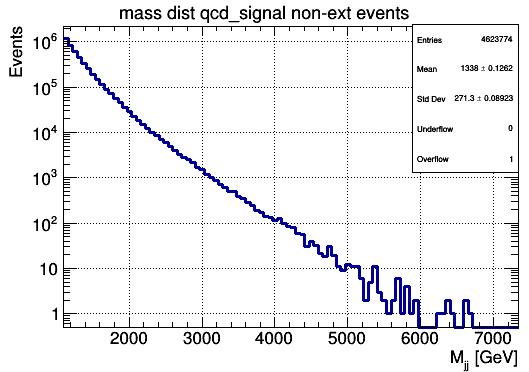

In [14]:
# plot mass dist full dataset
c = create_Canvas(size=(int(800/1.5),int(600/1.5)))
h_Mjj_train = create_TH1D(qcd_data_total['mJJ'], title='mass dist '+qr_data+' non-ext events', axis_title = ['M_{jj} [GeV]','Events'], 
                binning=[100, Mjj_selection, np.max(qcd_data_total['mJJ'])])

h_Mjj_train.Draw()
c.SetLogy()
c.Draw()
c.SaveAs(os.path.join(fig_dir,qr_data+'_total_mjj_hist.png'))

1155943 events for training


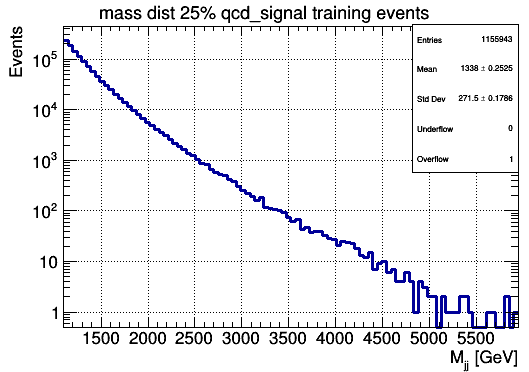

In [15]:
# plot mass dist chosen dataset
data_train = qcd_data_total[:int(N_evts*QR_train_share)]
#data_train = qcd_data_total
print(data_train.shape[0],'events for training')
c = create_Canvas(size=(int(800/1.5),int(600/1.5)))
h_Mjj_train = create_TH1D(data_train['mJJ'], title='mass dist '+str(int(QR_train_share*100))+'% '+qr_data+' training events', axis_title = ['M_{jj} [GeV]','Events'], 
                binning=[100, Mjj_selection, np.max(data_train['mJJ'])])

h_Mjj_train.Draw()
c.SetLogy()
c.Draw()
c.SaveAs(os.path.join(fig_dir,qr_data+'_'+str(int(QR_train_share*100))+'pct_training_mjj_hist.png'))

### Train the model to predict the cut

# DNN for quantile regression

In [16]:
def quantile_loss(target, pred):
    alpha = 1 - SM_eff
    err = target - pred
    return K.tf.where(err>=0, alpha*err, (alpha-1)*err)

def make_QR_model():

    inputs = Input(shape=(1,))
    hidden = Dense(100, activation='relu')(inputs)
    hidden = Dense(100, activation='relu')(hidden)
    hidden = Dense(100, activation='relu')(hidden)
    hidden = Dense(100, activation='relu')(hidden)
    hidden = Dense(100, activation='relu')(hidden)
    output = Dense(1)(hidden)
    model = Model(inputs, output)
    model.compile(loss=quantile_loss, optimizer=Adam(lr=1e-4))
    model.summary()
    return model


def fit_QR_model( model, x, y ):
    model.fit(scaleDownMjj(x), y, epochs=100, batch_size=1000, verbose=1, validation_split=0.2, shuffle=True, \
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1),ReduceLROnPlateau(factor=0.2, patience=3, verbose=1)])

model = make_QR_model()

x = np.reshape(data_train['mJJ'], (-1,1))
y = computeDiscriminatingVar(data_train)
print(x.shape)
print(y.shape)

fit_QR_model( model, x, y ) 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total para

2020-03-19 23:59:19.024473: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


In [11]:
import datetime
date = datetime.date.today().strftime("%m%d")
print(date)

0326


In [17]:
date = datetime.date.today()
date_str = '{}{:02d}{:02d}'.format(date.year, date.month, date.day)
model_str = qr_data+'_'+qr_train_share+'_qr_train_'+ quantile +'_'+ date_str
model.save('cut_models/dnn_cut_trained_{}.h5'.format(model_str))

In [18]:
# Compute weights to make it mass agnostic
# hM = h_Mjj_train.Clone('hM')
# print(hM.FindBin(10000))
# scale = np.sqrt(hM.GetMaximum()*hM.GetMinimum(0))
# print(scale)
# hM.Scale(1./scale)

# weights = np.ones_like(data_train[:,0])
# for i, m in enumerate(data_train[:,0]):
#     weights[i] = 1./hM.GetBinContent(hM.FindBin(m))
#     if i%1000000 == 0:
#         print(i)

In [19]:
#gbr_cut = GradientBoostingRegressor(loss='quantile', alpha=1-SM_eff,
#                                n_estimators=250, max_depth=3,
#                                learning_rate=.05, min_samples_leaf=30,
#                                min_samples_split=30,
#                                validation_fraction=0.5,
#                                n_iter_no_change=5,
#                                tol=1e-5,
#                                verbose=2)

In [20]:
#x = np.reshape(data_train[:,0], (-1,1))
#y = computeDiscriminatingVar(data_train)
#gbr_cut = joblib.load('cut_models/gbr_cut_trained_20191028_pval0p5947.joblib','r')
#gbr_cut.fit(x, y, sample_weight=None);

#date = datetime.date.today()
#date_str = '{}{:02d}{:02d}'.format(date.year, date.month, date.day)
#joblib.dump(gbr_cut, '../models/gbr_cut_trained_{}.joblib'.format(date_str)) 

((880.0, 6000.0), (0.0016734004, 0.36378682))


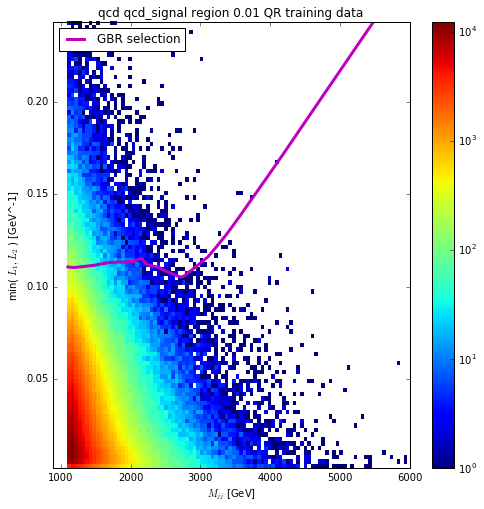

In [17]:
x = np.reshape(data_train['mJJ'], (-1,1))
plt.figure(figsize=(8, 8))
x_min = Mjj_selection*0.8
x_max = 6000. #np.percentile(x, 99.99)
#x_max = np.max(x)
print(((x_min , x_max), (np.min(y), np.max(y))))
plt.hist2d(x[:,0], y,
           range=((x_min , x_max), (np.min(y), np.percentile(y, 1e2*(1-1e-4)))), 
           norm=LogNorm(), bins=100,
           label='signal data'
          )

xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-Mjj_selection))
plt.plot(xs, model.predict( np.reshape(scaleDownMjj(xs), (-1,1)) ), '-', color='m', lw=3, label='GBR selection')

plt.ylabel('min( $L_1, L_2$ ) [GeV^-1]')
plt.xlabel('$M_{jj}$ [GeV]')
plt.title('qcd ' + qr_data + ' region '+ str(SM_eff) +' QR training data')
plt.colorbar()
plt.legend(loc='best')
plt.draw()
plt.savefig(os.path.join(fig_dir,'qcd_'+qr_data+'qr_selection_training_hist2d.png'))

In [22]:
#joblib.dump(gbr_cut, 'cut_models/gbr_cut_trained_{}.joblib'.format(date_str)) 

In [23]:
#model.save('cut_models/dnn_cut_trained_{}.h5'.format(date_str))

In [24]:
# from keras.models import load_model
# model = load_model('cut_models/dnn_cut_trained_20191030.h5')

In [18]:
def getSelection(x_Mjj, x_loss):
    cut = model.predict(np.reshape(x_Mjj, (-1,1)))
    return x_loss > cut.flatten()

In [19]:
def plotMassSpectrum(mJJ_pass, mJJ_rej, title=''):
    h_a = create_TH1D(mJJ_pass, 
                      name='h_acc', title='Accepted',
                      binning=binning,
                      opt='overflow'
                     )
    h_a.SetLineColor(2)
    h_a.SetStats(0)
    h_a.Sumw2()
    h_r = create_TH1D(mJJ_rej, 
                      name='h_rej', title='Rejected',
                      axis_title=['M_{jj} [GeV]', 'Events'],
                      binning=binning,
                      opt='overflow'
                     )
    h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
    h_r.SetStats(0)
    h_r.Sumw2()

    c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-4, 0.2], draw_opt = 'E', title=title)
    c.pad1.SetLogy()
    c.pad2.SetLogy()

    c.pad2.cd()
    c.ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    c.ln.SetLineWidth(2)
    c.ln.SetLineStyle(7)
    c.ln.SetLineColor(8)
    c.ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)

    c.Draw()
    return c

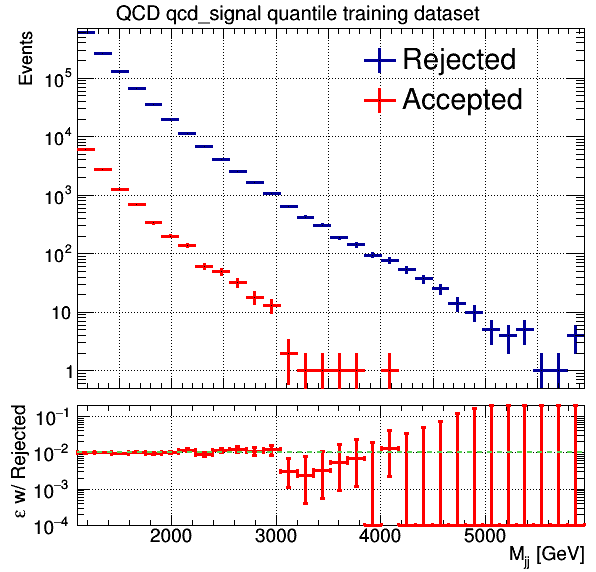

In [20]:
x = x.flatten()
binning=[30, Mjj_selection, np.max(x)]

sel = getSelection(scaleDownMjj(x), y)

c = plotMassSpectrum(x[sel], x[np.logical_not(sel)], 'QCD ' + qr_data + ' quantile training dataset')
h_a = c.h_list[1]
h_r = c.h_list[0]
c.SaveAs(os.path.join(fig_dir,'qcd_'+qr_data+'_mjj_selected_vs_rejected_hist.png'))

## regession cut at max mjj of accepted set

In [21]:
max_acc_mjj = np.max(x[sel])
max_total_mjj = np.max(x)
max_acc_loss_cut, = model.predict(np.reshape(max_acc_mjj,(-1,1)))
max_total_loss_cut, = model.predict(np.reshape(max_total_mjj,(-1,1)))
print(max_acc_mjj,": ", max_acc_loss_cut)
print(max_total_mjj,": ", max_total_loss_cut)

4077.2341 :  [452.87582]
5944.3286 :  [660.23663]


In [30]:
def getSelection_regressionCut(x_Mjj, x_loss):
    x_Mjj[x_Mjj > scaleDownMjj(max_acc_mjj)] = scaleDownMjj(max_acc_mjj) # cut values at max qcd accepted mjj
    cut = model.predict(np.reshape(x_Mjj, (-1,1)))
    return x_loss > cut.flatten()
    

# Define and test Hypotesis test

In [22]:
def HypotesisTets(h_a_bin_content, h_r_bin_content, eff, N_asymov = 10000, max_N_asymov = 1e7, show_hist=True):
    nu = eff*h_r_bin_content/(1-eff)

    probs_obs = sp.stats.poisson.pmf(h_a_bin_content.astype(np.int), nu)
    probs_obs = np.where(probs_obs < 1e-10, np.full_like(probs_obs, 1e-10), probs_obs)
    s_obs = np.sum(-np.log(probs_obs), axis=-1)
    print('S obs:', s_obs)

    N_worse = 0
    N_tot = 0
    loops = 0
    # toy generation
    while N_worse < 25 and N_tot < max_N_asymov:
        loops += 1
        if loops > 1 and loops%10 == 0:
            print(N_tot, N_worse)
        if loops == 10:
            print('Increasing by a factor 5 the number of asymov per loop')
            N_asymov *=5
        o_asymov = np.random.poisson(nu, (N_asymov, nu.shape[0]))
        probs = sp.stats.poisson.pmf(o_asymov, nu)
        probs = np.where(probs < 1e-10, np.full_like(probs, 1e-10), probs)
        nll = -np.log(probs)
        s_asymov = np.sum(nll, axis=-1)

        N_worse += np.sum(s_asymov > s_obs) # compare accepted-stats and toy-stats
        N_tot += N_asymov

        if max_N_asymov/N_tot < 25 and (N_worse * (max_N_asymov/N_tot) < 25):
            print('Will never have enough stat - giving up.')
            p_val = max(1, N_worse)/float(N_tot)
            return p_val

    print('Test stat reached after {} loops'.format(loops))

    p_val = max(1, N_worse)/float(N_tot)
    
    if show_hist:
        plt.figure()
        binContent, _, _ = plt.hist(s_asymov, label='Distribution assuming eff={:.1f}%'.format(100*eff))
        plt.plot([s_obs, s_obs], [0,np.max(binContent)], label='Observed')
        plt.legend(loc='best')
        plt.xlabel('Test statistic')
        plt.ylabel('Entries')
        plt.title('hypothesis test QR training qcd '+qr_data+ ', p-val = ' + str(p_val) )
        plt.savefig(os.path.join(fig_dir,'qcd_'+qr_data+'qr_selection_hist2d.png'))

    return p_val

S obs: 62.3294295436928
Test stat reached after 1 loops


0.6716

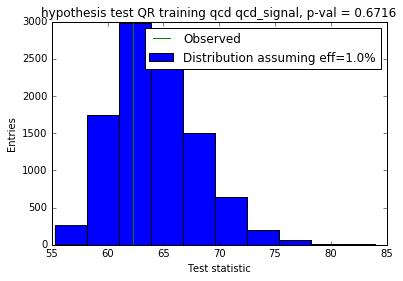

In [23]:
h_a_bin_content, _ = rootTH1_to_np(h_a)
h_r_bin_content, _ = rootTH1_to_np(h_r)
HypotesisTets(h_a_bin_content, h_r_bin_content, SM_eff, N_asymov=10000)

# Analyze signal region

In [30]:
print(base_dir)

sample_loc = {'qcdSigExt': base_dir + '/qcd_sqrtshatTeV_13TeV_PU40_EXT_ALL',  #_ALL # _ext + _ext2
              'GtoWW15': base_dir + '/RSGraviton_WW_NARROW_13TeV_PU40_1.5TeV',
              'GtoWW20': base_dir + '/RSGraviton_WW_NARROW_13TeV_PU40_2.0TeV',
              'GtoWW25': base_dir + '/RSGraviton_WW_NARROW_13TeV_PU40_2.5TeV',
              'GtoWW30': base_dir + '/RSGraviton_WW_NARROW_13TeV_PU40_3.0TeV',
              'GtoWW35': base_dir + '/RSGraviton_WW_NARROW_13TeV_PU40_3.5TeV',
              'GtoWW40': base_dir + '/RSGraviton_WW_NARROW_13TeV_PU40_4.0TeV',
              'GtoWW45': base_dir + '/RSGraviton_WW_NARROW_13TeV_PU40_4.5TeV',
              'AtoHZ': base_dir + '/AtoHZ_to_ZZZ_13TeV_PU40/',
              'GtoTTBroad': base_dir + '/RSGraviton_tt_BROAD_13TeV_PU40',
              'GtoTTNarr': base_dir + '/RSGraviton_tt_NARROW_13TeV_PU40'
             }

sample_label = {'qcdSigExt':r'QCD ext signal',
                'GtoWW15':r'$G(1.5 TeV)\to WW$',
                'GtoWW20':r'$G(2.0 TeV)\to WW$',
                'GtoWW25':r'$G(2.5 TeV)\to WW$',
                'GtoWW30':r'$G(3.0 TeV)\to WW$',
                'GtoWW35':r'$G(3.5 TeV)\to WW$',
                'GtoWW40':r'$G(4.0 TeV)\to WW$',
                'GtoWW45':r'$G(4.5 TeV)\to WW$',
                'AtoHZ':r'$A \to HZ \to ZZZ$',
                'GtoTTBroad':r'$G \to TT broad$',
                'GtoTTNarr':r'$G \to TT narrow$'
               }

sample_label_ROOT = {'qcdSigExt':'QCD ext signal',
                'GtoWW15':'G(1.5 TeV) to WW$',
                'GtoWW20':'$G(2.0 TeV) to WW$',
                'GtoWW25':'$G(2.5 TeV) to WW$',
                'GtoWW30':'$G(3.0 TeV) to WW$',
                'GtoWW35':'$G(3.5 TeV) to WW$',
                'GtoWW40':'$G(4.0 TeV) to WW$',
                'GtoWW45':'$G(4.5 TeV) to WW$',
                'AtoHZ':'A to HZ to ZZZ',
                'GtoTTBroad':'G to TT broad',
                'GtoTTNarr':'G to TT narrow'
               }

/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_without_pt_cut


In [24]:
# nGenEvts are updated when reading the data in -> correspond to actual numbers
sample_nGenEvts = {'qcdSig': (3826+2873)*10000, # TODO: adapt numbers! 
                   'GtoWW15': 99*10000,
                   'GtoWW20': 92*10000,
                   'GtoWW25': 92*10000,
                   'GtoWW30': 92*10000,
                   'GtoWW35': 92*10000,
                   'GtoWW40': 97*10000,
                   'GtoWW45': 97*10000,
                   'GtoWW15na':100*10000,
                     'GtoWW20na':100*10000,
                     'GtoWW25na':100*10000,
                     'GtoWW30na':100*10000,
                     'GtoWW35na':100*10000,
                     'GtoWW40na':100*10000,
                     'GtoWW45na':100*10000,
                     'GtoWW15br':100*10000,
                     'GtoWW20br':100*10000,
                     'GtoWW25br':100*10000,
                     'GtoWW30br':100*10000,
                     'GtoWW35br':100*10000,
                     'GtoWW40br':100*10000,
                     'GtoWW45br':100*10000,
                   'AtoHZ': 98*1000,
                   'GtoTTBroad': 98*1000,
                   'GtoTTNarr': 96*1000
                  }

sample_xsec = {'qcdSigBis': 8734.0 #pb
              }

In [25]:
print(sc.sample_loc.keys())
SM_samples = ['qcdSig', 'qcdSigBis']
BSM_samples = ['GtoWW15na', 'GtoWW20na', 'GtoWW25na', 'GtoWW30na', 'GtoWW35na', 'GtoWW40na', 'GtoWW45na', \
              'GtoWW15br', 'GtoWW20br', 'GtoWW25br', 'GtoWW30br', 'GtoWW35br', 'GtoWW40br', 'GtoWW45br']

['GtoWW25br', 'GtoWW45na', 'GtoWW15br', 'GtoTTBroad', 'qcdSide', 'AtoHZ', 'qcdSigBis', 'qcdSigExt', 'GtoWW20br', 'qcdSig', 'GtoWW15na', 'GtoWW40br', 'GtoWW35br', 'qcdSigExtAll', 'GtoWW45br', 'GtoWW20na', 'GtoWW30na', 'qcdSigExt2', 'qcdSigExt3', 'GtoWW30br', 'qcdSigExt4', 'qcdSigExt5', 'GtoWW35na', 'GtoWW40na', 'GtoWW25na', 'GtoTTNarr']


In [26]:
lumi_generated = sample_nGenEvts['qcdSigBis']/sample_xsec['qcdSigBis']
print('Lumi: {:.1f} pb^-1'.format(lumi_generated))

Lumi: 7670.0 pb^-1


### Get the data

In [27]:
result_data = {}
data = {}
sample_eff = {}
table = PrettyTable()
table.field_names = ['Sample', 'Trg evts', 'Eff. trg [%]', 'VAE sel. evts', 'Eff VAE [%]']

In [29]:
# read in data
all_samples = SM_samples + BSM_samples
labels = None
for n in all_samples:
    print(n)
    if n == 'qcdSigBis':
        sample = recarray_to_data( qcd_data_total[int(N_evts*QR_train_share):] ) # all of qcd already read in
        #sample, labels, N_evts = read_in_data( file_dir )
    else:
        sample, labels = read_results( os.path.join( sc.result_dir, sc.sample_loc[n] ) )
    result_data[n] = sample
    #sample_nGenEvts[n] = sample.shape[0]


qcdSigBis
GtoWW15na
('reading', '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_without_pt_cut/RSGraviton_WW_NARROW_13TeV_PU40_1.5TeV')
('reading ', '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_without_pt_cut/RSGraviton_WW_NARROW_13TeV_PU40_1.5TeV')
('num files in dir:', 99)
[--------------------]  0%('Labels:', array(['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M',
       'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j1RecoLoss',
       'j1KlLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss'], dtype='|S11'))
('\nnum files read in dir ', '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_without_pt_cut/RSGraviton_WW_NARROW_13TeV_PU40_1.5TeV', ': ', 99)
GtoWW20na
('reading', '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_without_pt_cut/RSGraviton_WW_NARROW_13TeV_PU40_2.0TeV')
('reading ', '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_no

GtoWW35br
('reading', '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_without_pt_cut/RSGraviton_WW_BROAD_13TeV_PU40_3.5TeV')
('reading ', '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_without_pt_cut/RSGraviton_WW_BROAD_13TeV_PU40_3.5TeV')
('num files in dir:', 97)
[--------------------]  0%('Labels:', array(['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M',
       'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j1RecoLoss',
       'j1KlLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss'], dtype='|S11'))
('\nnum files read in dir ', '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_without_pt_cut/RSGraviton_WW_BROAD_13TeV_PU40_3.5TeV', ': ', 97)
GtoWW40br
('reading', '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/training_without_pt_cut/RSGraviton_WW_BROAD_13TeV_PU40_4.0TeV')
('reading ', '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/pt_normalized/train

In [36]:
print(labels)
print(result_data)

['mJJ' 'j1Pt' 'j1Eta' 'j1Phi' 'j1M' 'j1E' 'j2Pt' 'j2M' 'j2E' 'DeltaEtaJJ'
 'DeltaPhiJJ' 'j1TotalLoss' 'j1RecoLoss' 'j1KlLoss' 'j2TotalLoss'
 'j2RecoLoss' 'j2KlLoss']
{'GtoWW45na': array([[ 3.53691626e+03,  2.01535889e+03,  2.84451097e-01, ...,
         3.27471459e-02,  3.06856964e-02,  4.12289858e+00],
       [ 3.72035059e+03,  1.88578967e+03,  6.06207252e-01, ...,
         1.14653952e-02,  9.96501812e-03,  3.00075412e+00],
       [ 4.15626123e+03,  2.13514575e+03,  2.79219985e-01, ...,
         1.00910918e-01,  9.90317306e-02,  3.75837421e+00],
       ...,
       [ 4.59724609e+03,  2.47251343e+03,  5.50273806e-03, ...,
         6.56922586e-02,  6.29716903e-02,  5.44113636e+00],
       [ 4.18880615e+03,  1.70216968e+03, -1.17915702e+00, ...,
         9.76882673e-02,  9.50448911e-02,  5.28675222e+00],
       [ 4.42976562e+03,  2.22731689e+03, -3.90999876e-02, ...,
         3.97867627e-02,  3.71575350e-02,  5.25845528e+00]]), 'GtoWW30br': array([[ 2.70453516e+03,  1.40477454e+03, -9.6365

In [31]:
# compute discriminating var and selection for data, print in table
for n in all_samples:
    x = result_data[n]
    dVar = computeDiscriminatingVar_str(x[:,-6],x[:,-3])
    sel = getSelection_regressionCut(scaleDownMjj(x[:,0]), dVar) # define sm (sel=0) & bsm (sel=1) membership
    x = np.column_stack((x, dVar, sel))
    print(x.shape[0])
    sample_eff[n] = float(x.shape[0])/sample_nGenEvts[n] # sample_eff == 1 if trigger eff = 100%

    dt = [(str(s),'<f4') for s in labels] + [('dVar','<f4')]
    dt += [('sel', '?')]
    data[n] = np.array(list(zip(*x.T)), dtype=dt)
    
    eff = '{:.2f}'.format(100.0*np.sum(data[n]['sel'])/float(data[n]['sel'].shape[0]))
    table.add_row([n, data[n]['sel'].shape[0], '{:.1f}'.format(100.0*sample_eff[n]), np.sum(data[n]['sel']), eff])

print(table)

3467831
448032
477149
512505
530775
488137
530031
432356
394521
446043
472902
486192
498566
503838
517498
+-----------+----------+--------------+---------------+-------------+
|   Sample  | Trg evts | Eff. trg [%] | VAE sel. evts | Eff VAE [%] |
+-----------+----------+--------------+---------------+-------------+
| qcdSigBis | 3467831  |     5.2      |     35111     |     1.01    |
| GtoWW15na |  448032  |     44.8     |     15735     |     3.51    |
| GtoWW20na |  477149  |     47.7     |     12454     |     2.61    |
| GtoWW25na |  512505  |     51.3     |     11091     |     2.16    |
| GtoWW30na |  530775  |     53.1     |      8594     |     1.62    |
| GtoWW35na |  488137  |     48.8     |      3563     |     0.73    |
| GtoWW40na |  530031  |     53.0     |      1567     |     0.30    |
| GtoWW45na |  432356  |     43.2     |      602      |     0.14    |
| GtoWW15br |  394521  |     39.5     |     13371     |     3.39    |
| GtoWW20br |  446043  |     44.6     |     11856     

In [32]:
print(sample_eff)

{'GtoWW45na': 0.432356, 'GtoWW30br': 0.486192, 'GtoWW25na': 0.512505, 'GtoWW25br': 0.472902, 'GtoWW20br': 0.446043, 'GtoWW15na': 0.448032, 'GtoWW40br': 0.503838, 'GtoWW15br': 0.394521, 'GtoWW35br': 0.498566, 'GtoWW35na': 0.488137, 'GtoWW30na': 0.530775, 'GtoWW45br': 0.517498, 'GtoWW40na': 0.530031, 'qcdSigBis': 0.051766397969846244, 'GtoWW20na': 0.477149}


In [33]:
for dataset in all_samples:
    x = data[dataset]
    print(dataset,': ',np.max(x['mJJ']))

qcdSigBis :  7338.6035
GtoWW15na :  6349.1357
GtoWW20na :  6498.414
GtoWW25na :  6329.5117
GtoWW30na :  7073.8706
GtoWW35na :  6971.132
GtoWW40na :  7445.161
GtoWW45na :  7676.179
GtoWW15br :  6969.629
GtoWW20br :  7690.3257
GtoWW25br :  8607.816
GtoWW30br :  8872.743
GtoWW35br :  10531.125
GtoWW40br :  9378.925
GtoWW45br :  9276.216


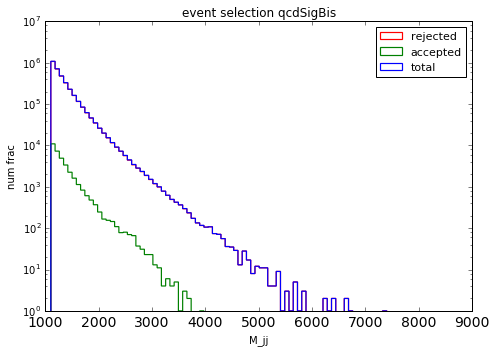

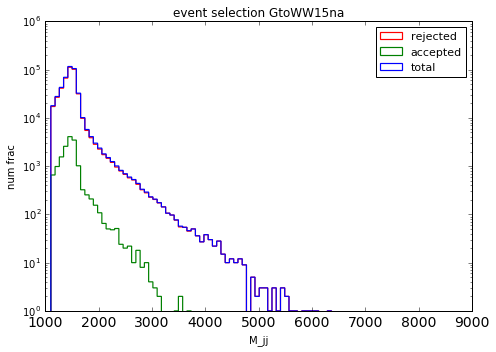

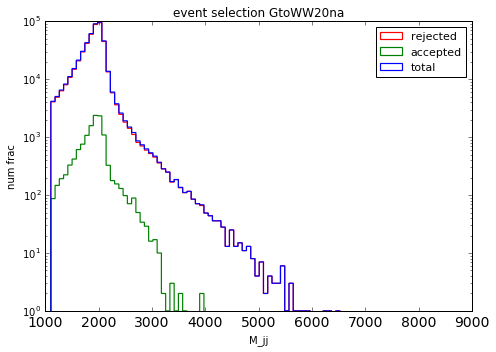

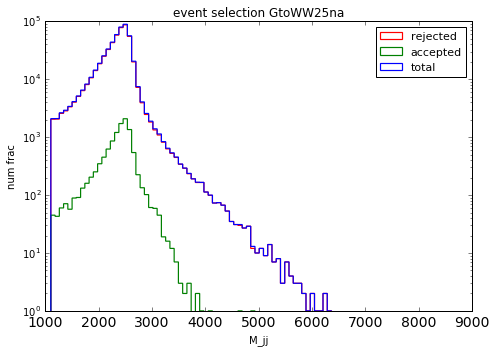

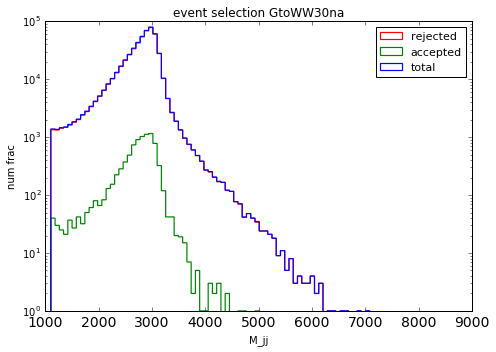

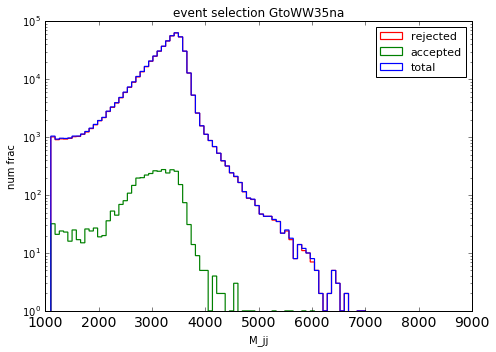

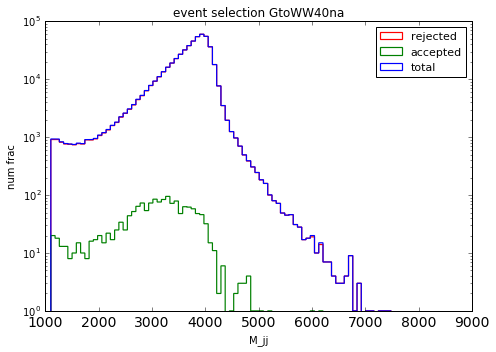

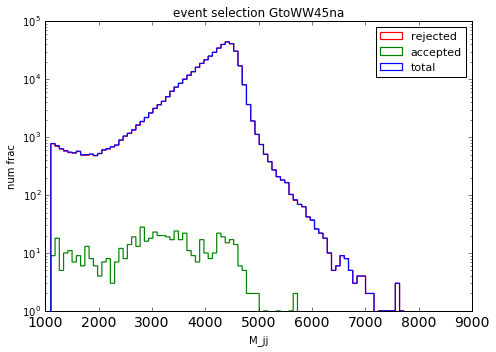

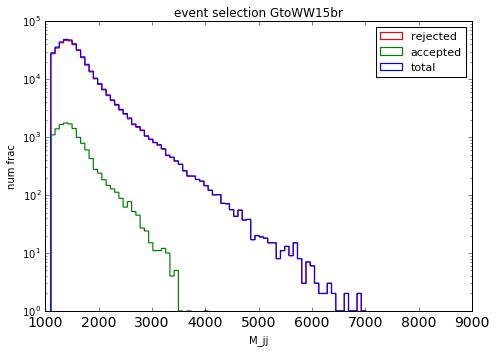

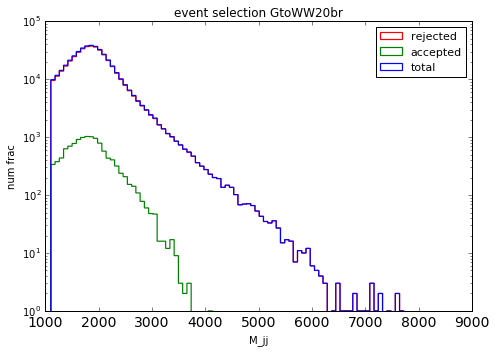

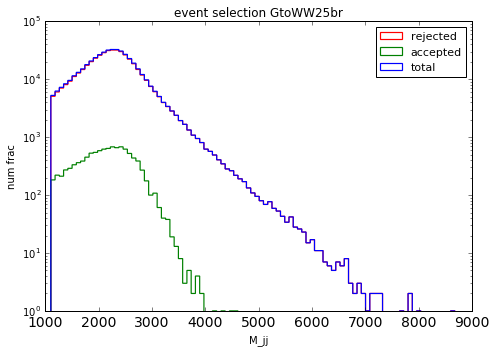

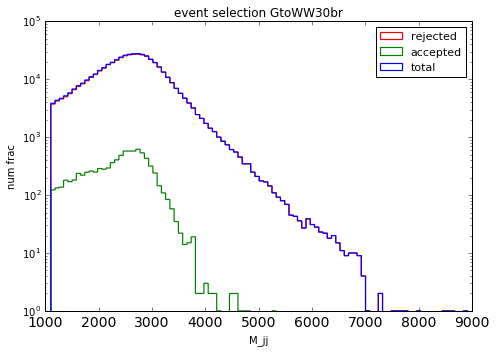

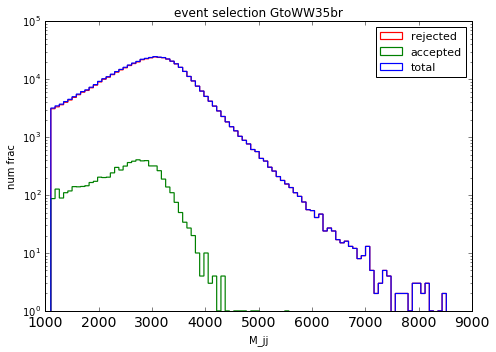

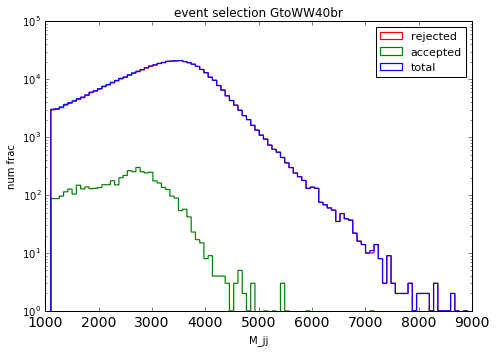

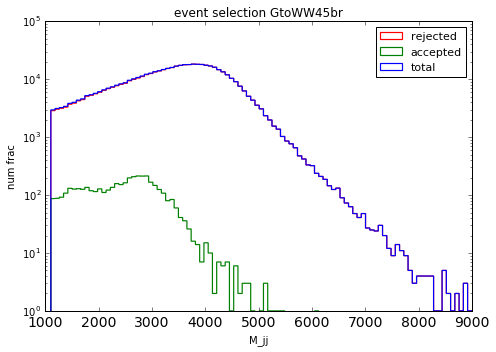

In [35]:
# compute bin counts for selected, rejected and total for combine input
import plotting_util as pu
reload(pu)
hist_data = [] # num signals X 2 (h_t, h_a) X num_bins (len(bin_edges)-1)
file_bin_counts = h5py.File(os.path.join(fig_dir,'vae_boost_bin_counts.h5'),'w')

bin_edges = np.linspace(1100,9000,100)

for dataset in all_samples:
    x = data[dataset]
    accepted = x[ x['sel'] ]
    rejected = x[ ~x['sel'] ]
    xx = [x['mJJ'], accepted['mJJ'], rejected['mJJ']]
    plot_name = dataset+'_event_selection'
    [h_t, h_a, h_r], _ = \
        pu.plot_hist( xx, xlabel='M_jj', bins=bin_edges, title='event selection ' + dataset, fig_dir=fig_dir, plot_name=plot_name, legend=['total','accepted','rejected'], normed=False)
    hist_data.append( np.stack( (h_t,h_a) ) )
    

file_bin_counts.create_dataset('bin_counts', data=np.asarray(hist_data))
file_bin_counts.create_dataset('bin_edges',data=bin_edges)
file_bin_counts.create_dataset('dataset_names',data=sc.sample_loc.keys())
file_bin_counts.close()

In [40]:
# for n, label in sample_label.iteritems():
#     x = data[n]
#     y = computeDiscriminatingVar_str(x['j1TotalLoss'],x['j2TotalLoss'])
#     plot_hist_2d(x['mJJ'],y, 'mass jj', 'L1+L2', 'mass vs loss ' + label, n)


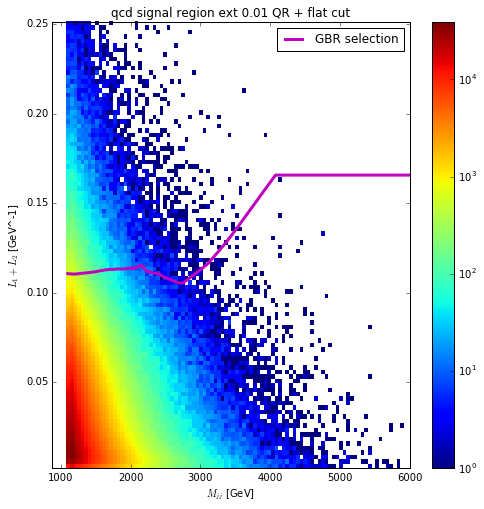

In [37]:
x = np.reshape(data['qcdSigBis']['mJJ'], (-1,1))
y = computeDiscriminatingVar_str(data['qcdSigBis']['j1TotalLoss'], data['qcdSigBis']['j2TotalLoss'])

plt.figure(figsize=(8, 8))
x_min = Mjj_selection*0.8
x_max = 6000.
plt.hist2d(x[:,0], y,
           range=((x_min , x_max), (np.min(y), np.percentile(y, 1e2*(1-1e-4)))), 
           norm=LogNorm(), bins=100,
           label='qcd signal ext'
          )

xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-Mjj_selection))
plt.plot(xs, model.predict(np.reshape(np.minimum(scaleDownMjj(xs),scaleDownMjj(max_acc_mjj)), (-1,1))), '-', color='m', lw=3, label='GBR selection')

plt.ylabel('$L_1 + L_2$ [GeV^-1]')
plt.xlabel('$M_{jj}$ [GeV]')
plt.title('qcd signal region ext '+ str(SM_eff) +' QR + flat cut')
plt.colorbar()
plt.legend(loc='best')
plt.draw()
plt.savefig(os.path.join(fig_dir,'qcd_'+qr_data+'qr_selection_applied_hist2d.png'))

### Define utilitities

In [41]:
def plotMassSpectrum_wSig(h_r, h_a, h_a_sig, name_BSM, lumi_text, p_val):
    h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
    h_r.SetStats(0)
    h_r.Sumw2()
    h_r.SetLineWidth(2)
    
    h_a.SetLineColor(2)
    h_a.SetStats(0)
    h_a.Sumw2()
    h_a.SetLineWidth(2)
    
    h_a_sig.SetFillStyle(3001)
    h_a_sig.SetFillColor(8)
    h_a_sig.SetLineWidth(0)

    c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-3, None], draw_opt = 'E')
    c.pad1.SetLogy()
    c.pad1.cd()
    h_a_sig.Draw('SAME')
    c.leg.AddEntry(h_a_sig, 'Acc. '+sc.sample_label[name_BSM], 'f')
    
    latex = rt.TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.SetTextAlign(31)
    t = c.pad1.GetTopMargin()
    r = c.pad1.GetRightMargin()
    latex.DrawLatex(1-r, 1-0.85*t, lumi_text)

    c.pad2.SetLogy()
    c.pad2.cd()
    c.ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    c.ln.SetLineWidth(2)
    c.ln.SetLineStyle(7)
    c.ln.SetLineColor(6)
    c.ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    
    latex.SetTextSize(0.1)
    latex.SetTextAlign(13)
    l = c.pad2.GetLeftMargin()
    t = c.pad2.GetTopMargin()
    latex.DrawLatex(l*1.1, 1-2*t, 'p-value: {:.1f} %'.format(100*p_val))

    c.Draw()
    return c

## Find the p-value as a function of xsec

In [42]:
lumi = 2000 #pb^-1

N_asymov = 10000
N_exp_per_xsec = 5

In [43]:
dic_p_val = {}
rt.gROOT.SetBatch(True)



GtoWW15na
xsec BSM 1.0e-03 pb
Experiment: 0
S obs: 64.38367343961019
Test stat reached after 1 loops
plotting GtoWW15na1.00e-03pb_L2000pb-1_wEff
Experiment: 1
S obs: 72.28660122138915
Test stat reached after 1 loops
Experiment: 2
S obs: 76.16764931655081
Test stat reached after 5 loops
Experiment: 3
S obs: 66.28845733850369
Test stat reached after 1 loops
Experiment: 4
S obs: 60.49734605516544
Test stat reached after 1 loops
xsec BSM 1.0e-02 pb
Experiment: 0
S obs: 75.98955445207142
Test stat reached after 6 loops
plotting GtoWW15na1.00e-02pb_L2000pb-1_wEff
Experiment: 1
S obs: 70.4099695647994
Test stat reached after 1 loops
Experiment: 2
S obs: 81.99268822199218
90000 1
Increasing by a factor 5 the number of asymov per loop
590000 8
1090000 16
Test stat reached after 38 loops
Experiment: 3
S obs: 63.061093065389315
Test stat reached after 1 loops
Experiment: 4
S obs: 67.57653844001887
Test stat reached after 1 loops
xsec BSM 1.0e-01 pb
Experiment: 0
S obs: 62.6431726881552
Test sta

Test stat reached after 1 loops
Experiment: 4
S obs: 72.94233999604032
Test stat reached after 1 loops
xsec BSM 1.0e-01 pb
Experiment: 0
S obs: 62.843415452419464
Test stat reached after 1 loops
plotting GtoWW30na1.00e-01pb_L2000pb-1_wEff
Experiment: 1
S obs: 64.42016965570912
Test stat reached after 1 loops
Experiment: 2
S obs: 72.17540007714041
Test stat reached after 1 loops
Experiment: 3
S obs: 67.46278103527843
Test stat reached after 1 loops
Experiment: 4
S obs: 63.93666102106906
Test stat reached after 1 loops
xsec BSM 1.0e+00 pb
Experiment: 0
S obs: 66.73114085093822
Test stat reached after 1 loops
plotting GtoWW30na1.00e+00pb_L2000pb-1_wEff
Experiment: 1
S obs: 63.28735795212825
Test stat reached after 1 loops
Experiment: 2
S obs: 71.83161348458809
Test stat reached after 1 loops
Experiment: 3
S obs: 62.569310337141566
Test stat reached after 1 loops
Experiment: 4
S obs: 65.91573615587151
Test stat reached after 1 loops
xsec BSM 1.0e+01 pb
Experiment: 0
S obs: 76.3466830555906

Test stat reached after 1 loops
Experiment: 2
S obs: 79.1779538519485
Test stat reached after 1 loops
Experiment: 3
S obs: 69.00479809714228
Test stat reached after 1 loops
Experiment: 4
S obs: 79.08583500366689
Test stat reached after 1 loops
xsec BSM 1.0e+01 pb
Experiment: 0
S obs: 141.00603093572212
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
plotting GtoWW45na1.00e+01pb_L2000pb-1_wEff
Experiment: 1
S obs: 132.57977722164472
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 2
S obs: 134.47830885722232
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 3
S obs: 138.9705959914842
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 4
S obs: 134.76036657278837
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never hav

Experiment: 1
S obs: 62.84741504413039
Test stat reached after 1 loops
Experiment: 2
S obs: 59.77689351981752
Test stat reached after 1 loops
Experiment: 3
S obs: 71.06650047394471
Test stat reached after 1 loops
Experiment: 4
S obs: 76.31413354345177
Test stat reached after 4 loops
xsec BSM 1.0e-01 pb
Experiment: 0
S obs: 65.65921377052854
Test stat reached after 1 loops
plotting GtoWW30br1.00e-01pb_L2000pb-1_wEff
Experiment: 1
S obs: 77.98076684288021
Test stat reached after 8 loops
Experiment: 2
S obs: 63.75759419717005
Test stat reached after 1 loops
Experiment: 3
S obs: 63.349996723131085
Test stat reached after 1 loops
Experiment: 4
S obs: 62.10319042225226
Test stat reached after 1 loops
xsec BSM 1.0e+00 pb
Experiment: 0
S obs: 75.33140219708662
Test stat reached after 2 loops
plotting GtoWW30br1.00e+00pb_L2000pb-1_wEff
Experiment: 1
S obs: 62.6473289289495
Test stat reached after 1 loops
Experiment: 2
S obs: 83.01373656649233
90000 2
Increasing by a factor 5 the number of asymo

S obs: 69.3466310583257
Test stat reached after 1 loops
Experiment: 2
S obs: 70.34281297290784
Test stat reached after 1 loops
Experiment: 3
S obs: 70.12594865237904
Test stat reached after 1 loops
Experiment: 4
S obs: 68.81810305877858
Test stat reached after 1 loops
xsec BSM 1.0e+01 pb
Experiment: 0
S obs: 119.26743515779798
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
plotting GtoWW45br1.00e+01pb_L2000pb-1_wEff
Experiment: 1
S obs: 117.70452022467666
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 2
S obs: 110.0837346399126
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 3
S obs: 122.22323804497032
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.
Experiment: 4
S obs: 120.55249305211711
90000 0
Increasing by a factor 5 the number of asymo

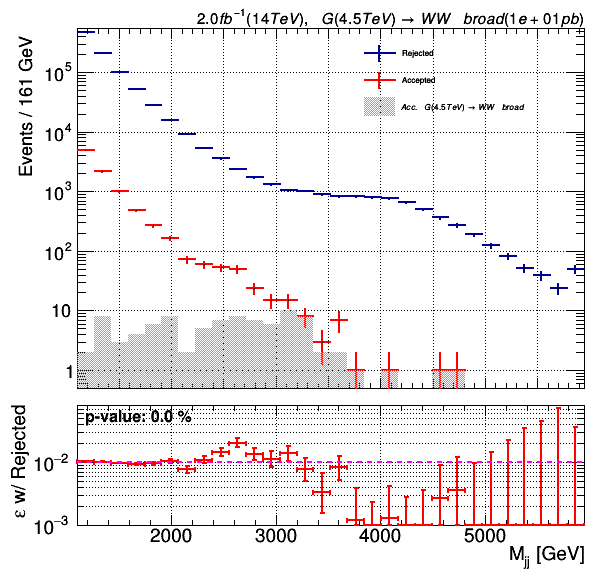

In [44]:
for name_BSM in BSM_samples: # for each BSM signal
    print('\n\n'+name_BSM)
    dic_p_val[name_BSM] = []
    # increasing cross section (p should be large at small xsec), xsec = 1 i.e. 10^1
    for xsec_BSM in np.logspace(-3, 1, 5): #(-4, 1, 8, endpoint=True): 
        print('xsec BSM {:.1e} pb'.format(xsec_BSM))
        lumi_text = '{:.1f} fb^{{-1}} (14 TeV), '.format(1e-3*lumi) + sc.sample_label[name_BSM] + ' ({:.2} pb)'.format(xsec_BSM)

        p_val_test = []
        for i_exp in range(N_exp_per_xsec): # for each xsec, do 5 experiments
            print('Experiment:', i_exp)
            d_obs = np.zeros((0,2))

            sample_xsec[name_BSM] = xsec_BSM
            for n in SM_samples + [name_BSM]: # create dataset with background and signal
                nExpEvts = lumi*sample_xsec[n]*sample_eff[n] # num expected events (?) (!!!)
                nEvts = np.random.poisson(nExpEvts)
                if data[n]['mJJ'].shape[0] < nEvts:
                    print('[WARNING] ' + n + ' re-use factor = {:.2f}'.format(float(nEvts)/data[n]['mJJ'].shape[0]))
                evtsIdx = np.random.randint(0, data[n]['mJJ'].shape[0], size=(nEvts,))

                # take nEvts (mass and selection) at random from dataset
                d_aux = np.column_stack((data[n]['mJJ'][evtsIdx], data[n]['sel'][evtsIdx])) 
                d_obs = np.concatenate((d_obs, d_aux)) # concatenate background and signal

            h_a = create_TH1D(d_obs[:, 0][d_obs[:,1].astype(np.bool)], 
                                 name='h_acc', title='Accepted',
                                 binning=binning,
                                 opt='overflow')

            h_r = create_TH1D(d_obs[:, 0][np.logical_not(d_obs[:,1]).astype(np.bool)], 
                                 name='h_rej', title='Rejected',
                                 axis_title=['M_{jj} [GeV]', ''],
                                 binning=binning,
                                 opt='overflow'
                                )
            h_r.SetYTitle('Events / {:.0f} GeV'.format(h_r.GetBinWidth(1)))

            h_a_bin_content, _ = rootTH1_to_np(h_a)
            h_r_bin_content, _ = rootTH1_to_np(h_r)
            # do hypothesis test with mixed background-signal dataset
            p_val = HypotesisTets(h_a_bin_content, h_r_bin_content, SM_eff, N_asymov = N_asymov, show_hist=False)
            p_val_test.append(p_val)

            if i_exp > 3 and np.max(p_val_test) == 0:
                break

            if i_exp == 0:
                h_a_sig = create_TH1D(d_obs[-nEvts-1:, 0][d_obs[-nEvts-1:, 1].astype(np.bool)], 
                                     name='h_acc', title='Accepted',
                                     binning=binning,
                                     opt='overflow')
                
                c = plotMassSpectrum_wSig(h_r, h_a, h_a_sig, name_BSM, lumi_text, p_val)
                fig_name = name_BSM + '{:1.2e}'.format(xsec_BSM) + 'pb' + '_L' + str(lumi) + 'pb-1_wEff'
                print('plotting', fig_name)
                c.SaveAs(os.path.join(fig_dir,fig_name + '.png'))
                #c.Draw()
                
        aux = [xsec_BSM] + list(np.percentile(p_val_test, [2.5, 16, 50, 84, 97.5]))
        dic_p_val[name_BSM].append(aux)
    

# Make the p-value plot

In [46]:
sample_col = {
              'GtoWW1':'b',
              'GtoWW2':'g',
              'GtoWW3':'r',
              'GtoWW4':'m',
              'AtoHZ':'y',
              'GtoTTBroad':'k',
              'GtoTTNarr':'c'
             }

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01] [1.99000000e-02 6.41000000e-02 5.05000000e-02 2.45000000e-02
 2.27272727e-06]
[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01] [1.09000000e-01 1.09900000e-01 2.09100000e-01 1.65000000e-03
 2.47706422e-05]
[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01] [1.91000000e-02 3.31000000e-02 4.94000000e-02 2.11000000e-02
 2.27272727e-06]
[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01] [2.01900000e-01 2.56100000e-01 1.74800000e-01 1.24000000e-01
 5.91836735e-05]
[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01] [0.1925 0.0698 0.2519 0.1766 0.0083]
[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01] [0.1011  0.0118  0.2946  0.0259  0.00035]
[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01] [2.12600000e-01 2.52000000e-02 7.40000000e-02 9.80000000e-03
 2.27272727e-06]
[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01] [0.0571 0.193  0.0816 0.0138 0.0128]
[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01] [2.67000000e-02 1.36500000e-01 2.89000000e-02 7.64000000e-02
 2.27272727e-06]
[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01] [6.31000000e-02 3.15300000e-01 1.72200000e-01 

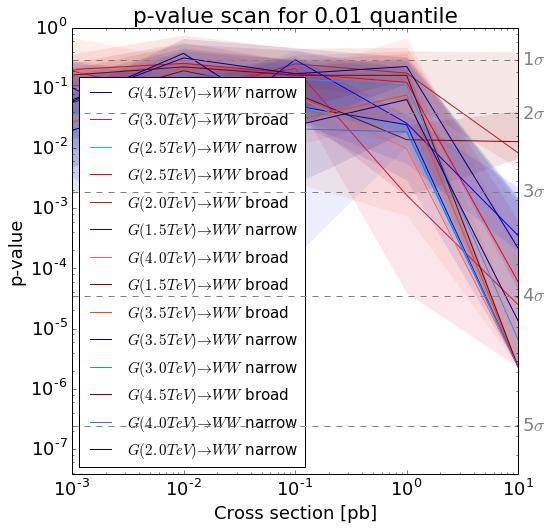

In [45]:
matplotlib.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(8,8))


for n, val_aux in dic_p_val.iteritems():
    val_aux = np.array(val_aux)
    x_sec = val_aux[:, 0]
    quant = val_aux[:, 1:]
    
    ax1.plot(x_sec, quant[:, 2], color=sc.color[n], label=sc.sample_label[n])
    print(x_sec, quant[:,2])
    ax1.fill_between(x_sec, quant[:, 1], quant[:, 3], color=sc.color[n], alpha = 0.1, lw=0)
#     ax1.fill_between(x_sec, quant[:, 0], quant[:, 4], color=sample_col[n], alpha = 0.1, lw=0)
    
    
plt.xscale('log')
plt.xlabel('Cross section [pb]')
plt.yscale('log')
plt.ylabel('p-value')
plt.ylim(1 - erf(5.5/np.sqrt(2)), 1)
plt.legend(loc='lower left',prop={'size': 15})
ax2 = ax1.twinx()
for i in range(1, 6):
    p = 1 - erf(i/np.sqrt(2))
    ax2.plot([x_sec[0], x_sec[-1]], 2*[p], '--', color='grey')
plt.yscale('log')
plt.title('p-value scan for ' + str(SM_eff) + ' quantile')
ax2.set_yticks(1 - erf(np.arange(1,6)/np.sqrt(2)))
ax2.set_yticklabels(['{}$\sigma$'.format(i) for i in range(1,6)])
ax2.tick_params(axis='y', labelcolor='grey')
fig.savefig(os.path.join(fig_dir,'pValueScan_L' + str(lumi) + 'pb-1.png'), bbox_inches='tight')